<a href="https://colab.research.google.com/github/LineIntegralx/CalligraNet/blob/main/EDA%20%26%20Preprocessing/EDA_%26_Preprocessing_HICMA_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
from pathlib import Path

# 🔹 CHANGE THIS to the folder that contains Set1, Set2, Set3
BASE_DIR = Path("/content/drive/MyDrive/EECE693_Project/Full_Dataset")

# Quick check
list(BASE_DIR.iterdir())


[PosixPath('/content/drive/MyDrive/EECE693_Project/Full_Dataset/Set2'),
 PosixPath('/content/drive/MyDrive/EECE693_Project/Full_Dataset/Set3'),
 PosixPath('/content/drive/MyDrive/EECE693_Project/Full_Dataset/Set1')]

# **--------------Merging----------------**

In [7]:
ALL_DIR = BASE_DIR / "All"
IMAGES_OUT = ALL_DIR / "images"

ALL_DIR.mkdir(exist_ok=True)
IMAGES_OUT.mkdir(parents=True, exist_ok=True)

ALL_DIR, IMAGES_OUT


(PosixPath('/content/drive/MyDrive/EECE693_Project/Full_Dataset/All'),
 PosixPath('/content/drive/MyDrive/EECE693_Project/Full_Dataset/All/images'))

In [5]:
from pathlib import Path
import pandas as pd

BASE_DIR = Path("/content/drive/MyDrive/EECE693_Project/Full_Dataset")
sets = ["Set1", "Set2", "Set3"]

for s in sets:
    set_dir = BASE_DIR / s
    csv_path = set_dir / "labels.csv"
    img_dir = set_dir / "images"

    df = pd.read_csv(csv_path)
    first_col = df.columns[0]
    if first_col.lower().startswith("unnamed"):
        df = df.drop(columns=[first_col])

    missing = []
    for name in df["img_name"]:
        name_clean = str(name).strip()
        if not (img_dir / name_clean).exists():
            missing.append(name_clean)

    print(f"{s}: missing {len(missing)} files")
    print(missing[:10])


Set1: missing 3 files
['109-kaferon-black_segment_no_0 - Copy (2) (1).jpg', '109-kaferon-black_segment_no_0 - Copy (4) (1).jpg', '109-kaferon-black_segment_no_0 (1).jpg']
Set2: missing 0 files
[]
Set3: missing 0 files
[]


In [8]:
import pandas as pd
import shutil
from pathlib import Path

BASE_DIR = Path("/content/drive/MyDrive/EECE693_Project/Full_Dataset")
ALL_DIR = BASE_DIR / "All"
IMAGES_OUT = ALL_DIR / "images"
ALL_DIR.mkdir(exist_ok=True)
IMAGES_OUT.mkdir(parents=True, exist_ok=True)

sets = ["Set1", "Set2", "Set3"]
all_dfs = []
missing_global = []

for s in sets:
    set_dir = BASE_DIR / s
    csv_path = set_dir / "labels.csv"
    img_dir = set_dir / "images"

    print(f"Processing {s} ...")

    df = pd.read_csv(csv_path)
    first_col = df.columns[0]
    if first_col.lower().startswith("unnamed"):
        df = df.drop(columns=[first_col])

    new_names = []
    keep_rows = []

    for idx, img_name in enumerate(df["img_name"]):
        img_name_clean = str(img_name).strip()   # 🔹 strip spaces
        src = img_dir / img_name_clean

        if not src.exists():
            missing_global.append((s, img_name_clean))
            continue  # 🔹 skip this row

        # avoid overwriting if same name appears in another set
        new_name = img_name_clean
        dst = IMAGES_OUT / new_name
        counter = 1
        while dst.exists():
            stem = Path(img_name_clean).stem
            suffix = Path(img_name_clean).suffix
            new_name = f"{stem}_{s}_v{counter}{suffix}"
            dst = IMAGES_OUT / new_name
            counter += 1

        shutil.copy2(src, dst)
        new_names.append(new_name)
        keep_rows.append(idx)

    # Keep only rows whose image existed
    df = df.iloc[keep_rows].copy()
    df["img_name"] = new_names
    df["source_set"] = s
    all_dfs.append(df)

merged_df = pd.concat(all_dfs, ignore_index=True)
merged_df.to_csv(ALL_DIR / "labels.csv", index=False)

print("✅ Done merging!")
print("Total merged rows:", len(merged_df))
print("Total images:", len(list(IMAGES_OUT.glob('*'))))
print("Missing files total:", len(missing_global))
print("First few missing:", missing_global[:10])


Processing Set1 ...
Processing Set2 ...
Processing Set3 ...
✅ Done merging!
Total merged rows: 5032
Total images: 5032
Missing files total: 3
First few missing: [('Set1', '109-kaferon-black_segment_no_0 - Copy (2) (1).jpg'), ('Set1', '109-kaferon-black_segment_no_0 - Copy (4) (1).jpg'), ('Set1', '109-kaferon-black_segment_no_0 (1).jpg')]


# **--------------EDA----------------**

In [9]:
from google.colab import drive
drive.mount('/content/drive')

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import random
from collections import Counter


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
BASE_DIR = Path("/content/drive/MyDrive/EECE693_Project/Full_Dataset")
ALL_DIR = BASE_DIR / "All"
IMG_DIR = ALL_DIR / "images"
CSV_PATH = ALL_DIR / "labels.csv"

print(ALL_DIR)
print(IMG_DIR.exists(), CSV_PATH.exists())


/content/drive/MyDrive/EECE693_Project/Full_Dataset/All
True True


In [11]:
df = pd.read_csv(CSV_PATH)
df.head()


,img_name,class,label,source_set
0,012-Al-Baqara-2-156-Thuluth_segment_no_0.jpg,Thuluth,انا لله وانا اليه راجعون,Set1
1,013-3-Al-Imran-37-Thuluth_segment_no_0.jpg,Thuluth,كلما دخل عليها زكريا المحراب وجد عندها رزقا,Set1
2,013-3-Al-Imran-37-Thuluth_segment_no_1.jpg,Thuluth,قال يا مريم أن لك هذا قالت هو من عند الله إن ا...,Set1
3,02-Al-Fath-48-1to4-ThuluthNaskh-2_segment_no_0...,Thuluth,بسم الله الرحمن الرحيم إنا فتحنا لك فتحا مبينا...,Set1
4,02-Al-Fath-48-1to4-ThuluthNaskh-2_segment_no_5...,Thuluth,بسم الله الرحمن الرحيم,Set1


In [12]:
df.info()
df.isna().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5032 entries, 0 to 5031
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   img_name    5032 non-null   object
 1   class       5032 non-null   object
 2   label       5032 non-null   object
 3   source_set  5032 non-null   object
dtypes: object(4)
memory usage: 157.4+ KB


,0
img_name,0
class,0
label,0
source_set,0


In [13]:
print("Total samples:", len(df))
print("Columns:", df.columns.tolist())
print(df["class"].value_counts())


Total samples: 5032
Columns: ['img_name', 'class', 'label', 'source_set']
class
Naskh       3735
Thuluth     1010
Diwani       243
Kufic         27
Muhaquaq      17
Name: count, dtype: int64


In [15]:
style_counts = df["class"].value_counts().sort_values(ascending=False)
style_counts


,count
class,
Naskh,3735
Thuluth,1010
Diwani,243
Kufic,27
Muhaquaq,17


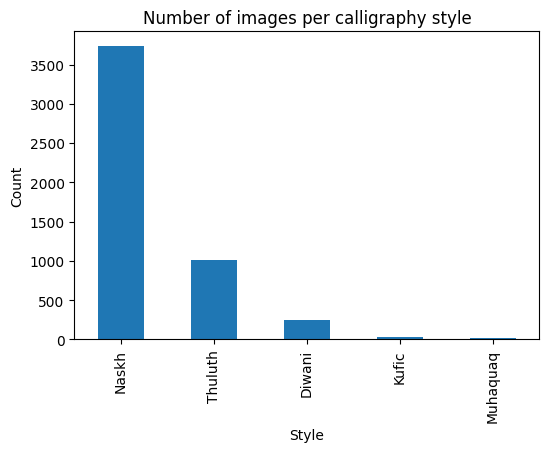

In [16]:
plt.figure(figsize=(6,4))
style_counts.plot(kind="bar")
plt.title("Number of images per calligraphy style")
plt.xlabel("Style")
plt.ylabel("Count")
plt.show()


In [17]:
heights = []
widths = []
aspect_ratios = []
pixels = []
missing_imgs = []

for img_name in df["img_name"]:
    path = IMG_DIR / img_name
    if not path.exists():
        missing_imgs.append(img_name)
        continue
    with Image.open(path) as im:
        w, h = im.size
    widths.append(w)
    heights.append(h)
    aspect_ratios.append(w / h)
    pixels.append(w * h)

print("Missing images:", len(missing_imgs))


Missing images: 0


In [18]:
df_dims = df.copy()
df_dims["width"] = widths
df_dims["height"] = heights
df_dims["aspect_ratio"] = aspect_ratios
df_dims["pixels"] = pixels

df_dims[["width","height","aspect_ratio","pixels"]].describe()


,width,height,aspect_ratio,pixels
count,5032.000000,5032.000000,5032.000000,5.032000e+03
mean,2665.975954,424.505366,7.712783,1.236151e+06
std,1464.629010,436.491217,3.661229,1.712088e+06
min,130.000000,21.000000,0.315107,4.536000e+03
25%,1657.000000,249.000000,5.714142,4.203698e+05
50%,1913.000000,328.000000,6.921488,5.956840e+05
75%,3827.000000,390.000000,10.560912,1.730080e+06
max,9000.000000,6066.000000,17.626263,3.237424e+07


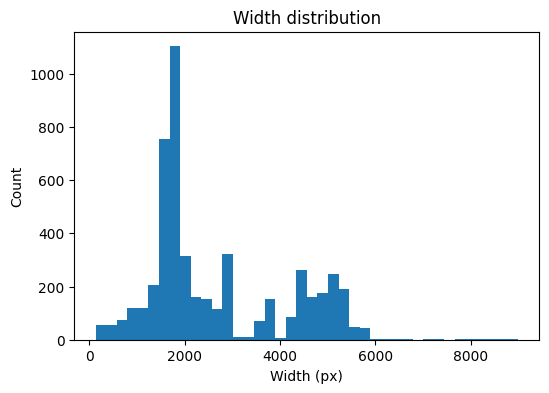

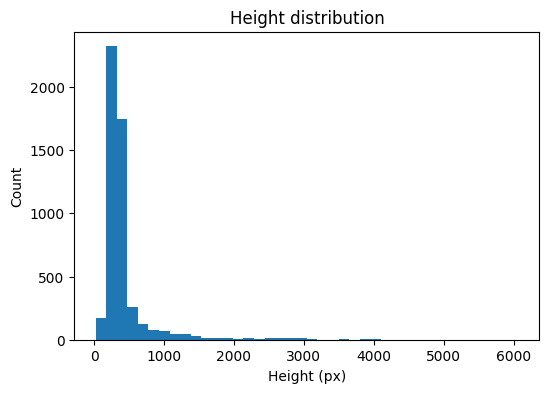

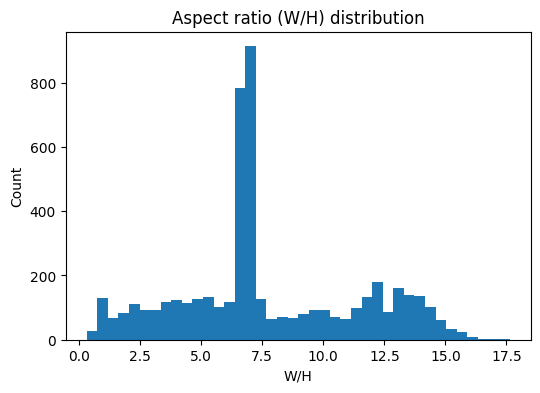

In [19]:
plt.figure(figsize=(6,4))
plt.hist(widths, bins=40)
plt.title("Width distribution")
plt.xlabel("Width (px)")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(6,4))
plt.hist(heights, bins=40)
plt.title("Height distribution")
plt.xlabel("Height (px)")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(6,4))
plt.hist(aspect_ratios, bins=40)
plt.title("Aspect ratio (W/H) distribution")
plt.xlabel("W/H")
plt.ylabel("Count")
plt.show()


In [20]:
means = []
stds = []

for img_name in df["img_name"]:
    path = IMG_DIR / img_name
    if not path.exists():
        continue
    img = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    means.append(img.mean())
    stds.append(img.std())

print("Global mean intensity:", np.mean(means))
print("Global std intensity:", np.mean(stds))


Global mean intensity: 163.4265419309625
Global std intensity: 53.46460342242215


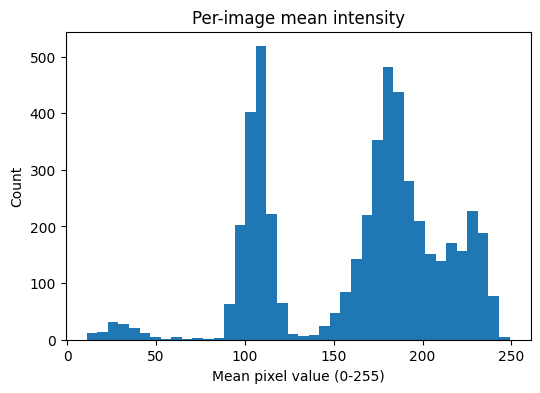

In [21]:
plt.figure(figsize=(6,4))
plt.hist(means, bins=40)
plt.title("Per-image mean intensity")
plt.xlabel("Mean pixel value (0-255)")
plt.ylabel("Count")
plt.show()


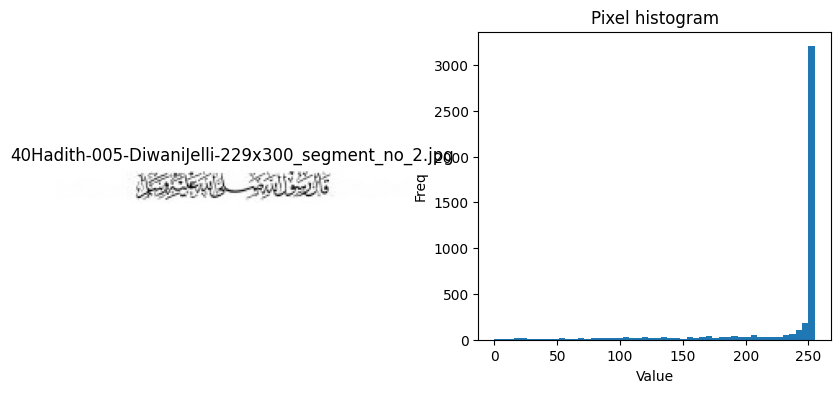

In [22]:
sample_path = IMG_DIR / random.choice(df["img_name"].tolist())
img = cv2.imread(str(sample_path), cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.title(sample_path.name)

plt.subplot(1,2,2)
plt.hist(img.flatten(), bins=50)
plt.title("Pixel histogram")
plt.xlabel("Value")
plt.ylabel("Freq")
plt.show()


In [23]:
df["char_len"] = df["label"].astype(str).apply(len)
df["word_len"] = df["label"].astype(str).apply(lambda x: len(x.split()))

df[["char_len","word_len"]].describe()


,char_len,word_len
count,5032.000000,5032.000000
mean,42.624603,8.578895
std,20.082180,4.013064
min,3.000000,1.000000
25%,34.750000,7.000000
50%,43.000000,9.000000
75%,49.000000,10.000000
max,341.000000,58.000000


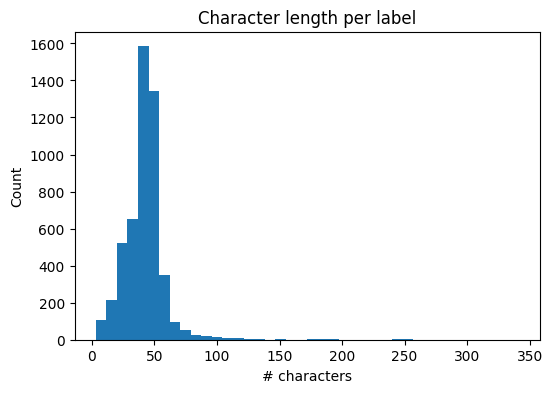

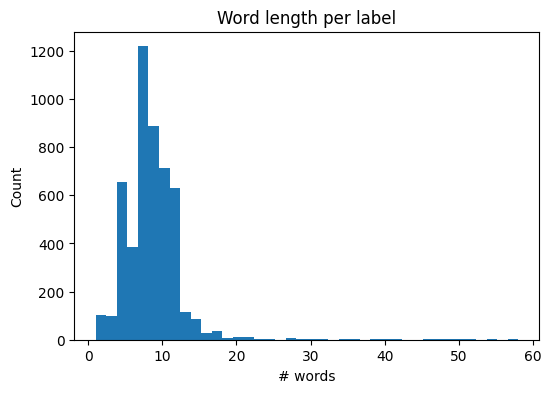

In [24]:
plt.figure(figsize=(6,4))
plt.hist(df["char_len"], bins=40)
plt.title("Character length per label")
plt.xlabel("# characters")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(6,4))
plt.hist(df["word_len"], bins=40)
plt.title("Word length per label")
plt.xlabel("# words")
plt.ylabel("Count")
plt.show()


In [25]:
all_text = "".join(df["label"].astype(str).tolist())
char_counts = Counter(all_text)

print("Total unique chars:", len(char_counts))
char_counts.most_common(30)[:30]


Total unique chars: 48


[(' ', 38686),
 ('ا', 26218),
 ('ل', 23609),
 ('م', 14558),
 ('و', 12229),
 ('ن', 11503),
 ('ي', 11229),
 ('ه', 7978),
 ('ر', 6724),
 ('ب', 5983),
 ('ع', 5896),
 ('ت', 5024),
 ('ك', 4920),
 ('د', 4120),
 ('ف', 3754),
 ('س', 3685),
 ('ح', 3445),
 ('ق', 3141),
 ('أ', 2701),
 ('ى', 2159),
 ('ص', 1964),
 ('ذ', 1865),
 ('ة', 1585),
 ('ج', 1562),
 ('إ', 1307),
 ('خ', 1231),
 ('ش', 1194),
 ('ض', 870),
 ('ز', 789),
 ('ء', 735)]

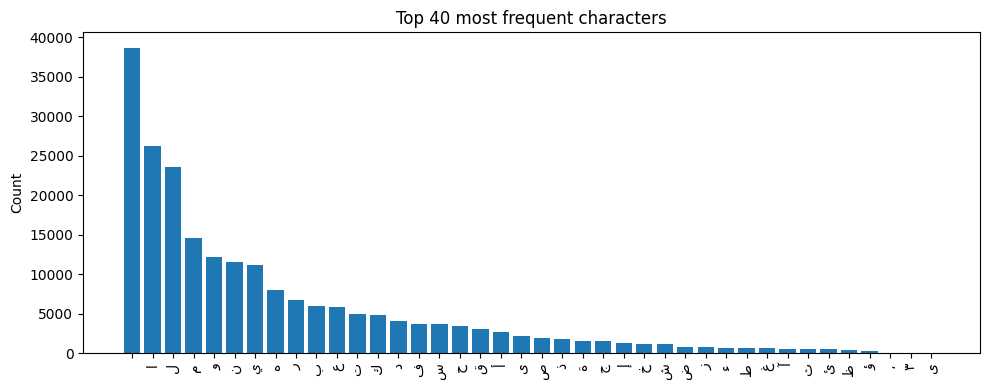

In [26]:
top_n = 40
chars, counts = zip(*char_counts.most_common(top_n))

plt.figure(figsize=(10,4))
plt.bar(range(len(chars)), counts)
plt.xticks(range(len(chars)), chars, rotation=90)
plt.title(f"Top {top_n} most frequent characters")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


In [27]:
def show_random_grid(style, n=6):
    subset = df[df["class"] == style]
    sample = subset.sample(min(n, len(subset)), random_state=42)
    images = [IMG_DIR / name for name in sample["img_name"]]

    cols = 3
    rows = int(np.ceil(len(images)/cols))
    plt.figure(figsize=(12, 4*rows))

    for i, path in enumerate(images, 1):
        img = Image.open(path).convert("RGB")
        plt.subplot(rows, cols, i)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"{style}\n{path.name}")
    plt.suptitle(f"Random {style} samples", fontsize=16)
    plt.tight_layout()
    plt.show()


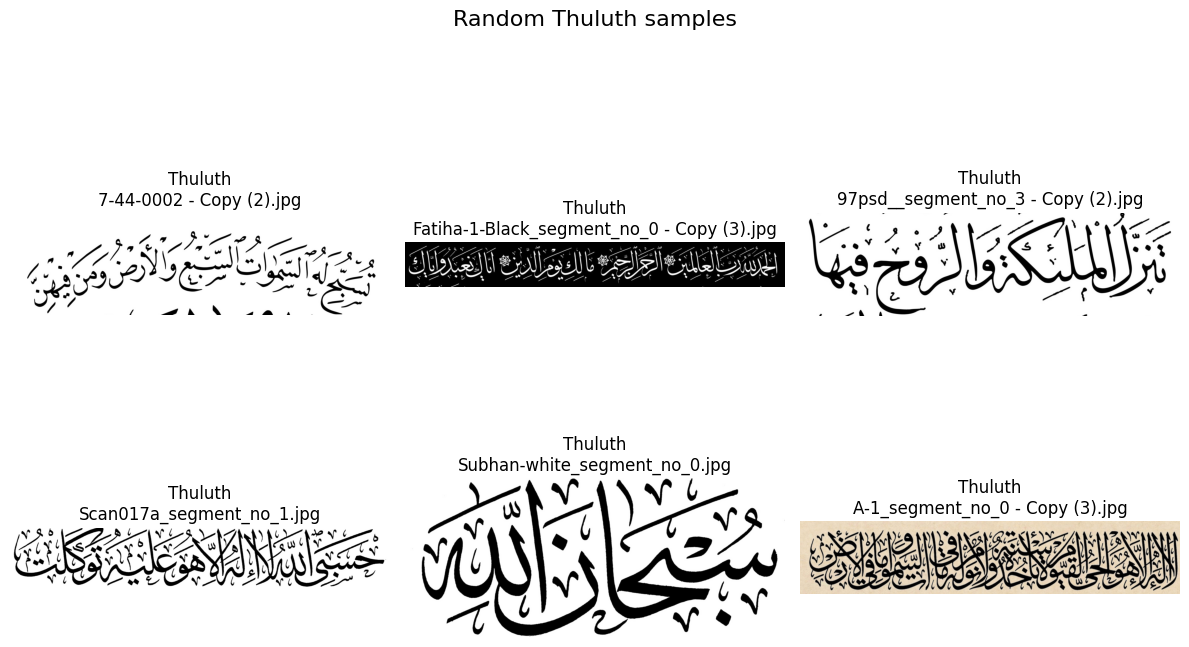

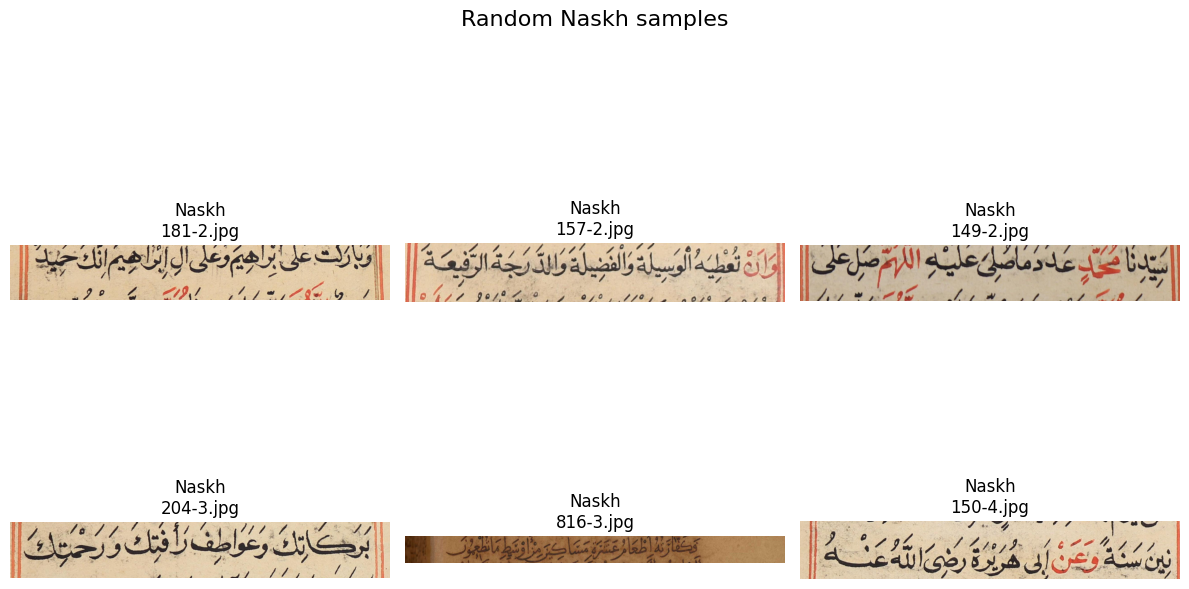

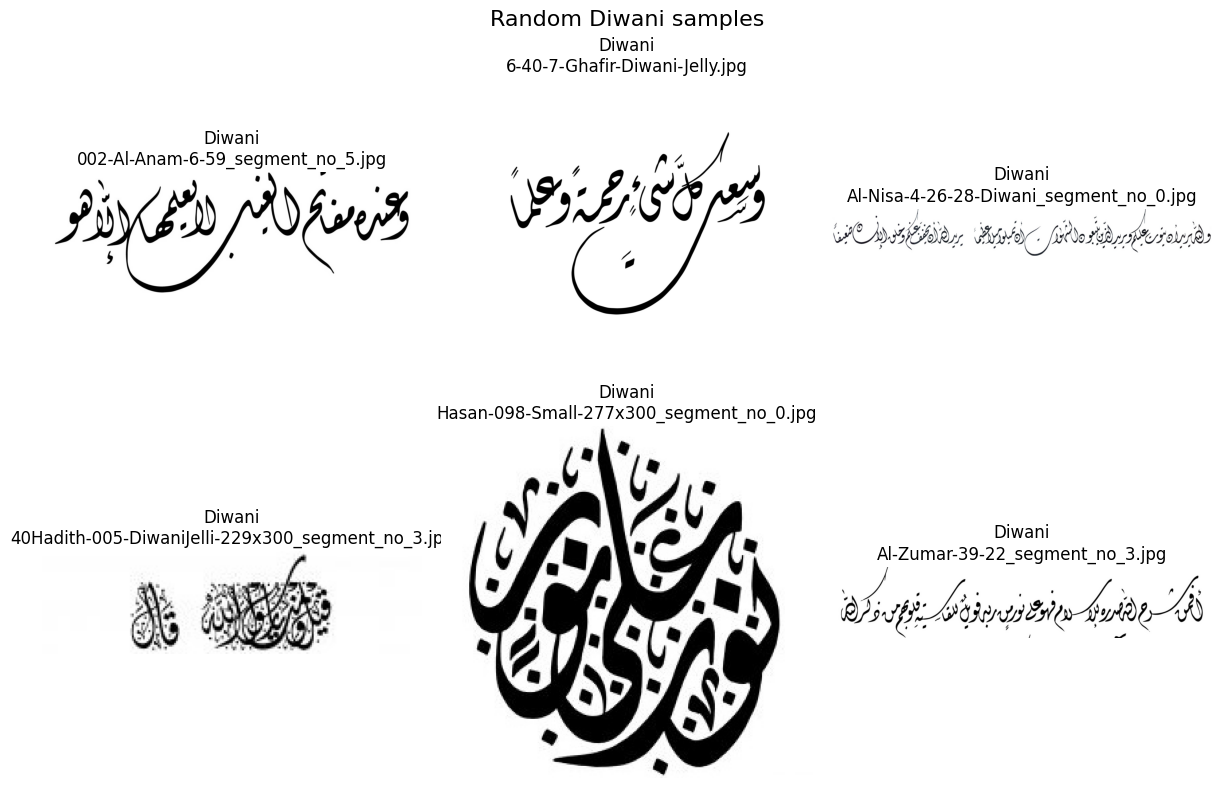

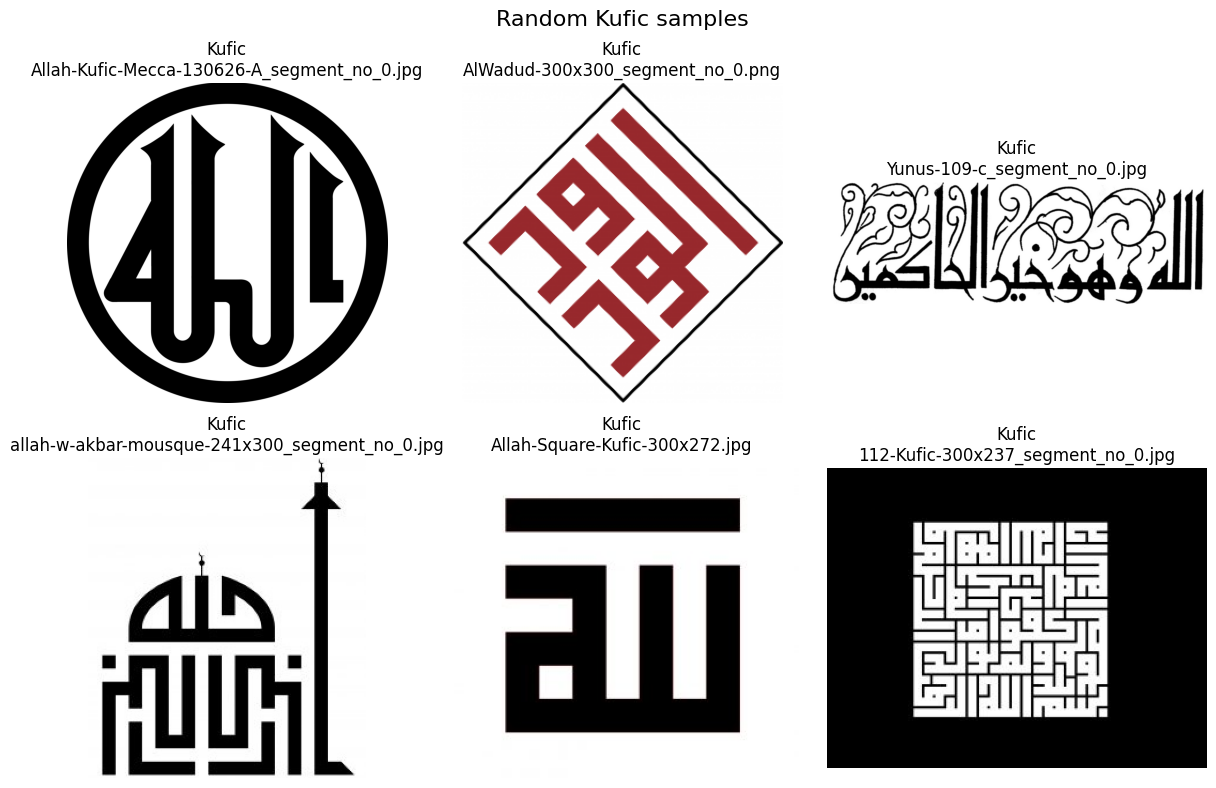

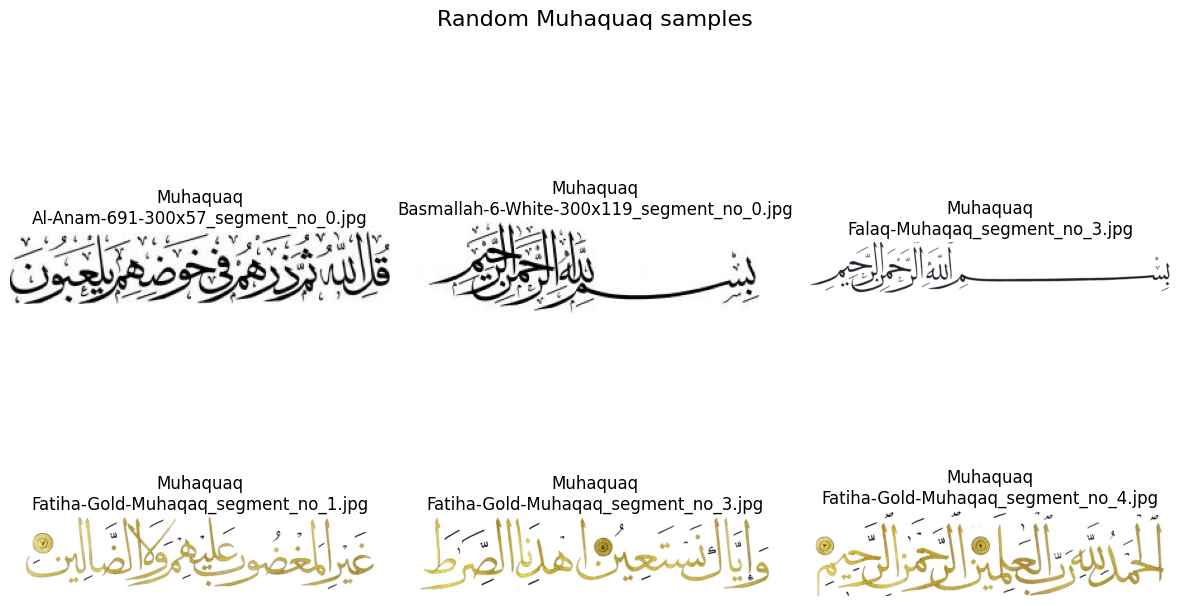

In [28]:
for style in df["class"].unique():
    show_random_grid(style, n=6)


In [29]:
bad_files = []
tiny_files = []

for img_name in df["img_name"]:
    path = IMG_DIR / img_name
    try:
        with Image.open(path) as im:
            w, h = im.size
    except Exception as e:
        bad_files.append((img_name, str(e)))
        continue

    if w < 50 or h < 50:
        tiny_files.append((img_name, w, h))

print("Corrupted files:", len(bad_files))
print("Tiny files (<50px):", len(tiny_files))
bad_files[:5], tiny_files[:5]


Corrupted files: 0
Tiny files (<50px): 7


([],
 [('2-39-9-Al-Zumar-Diwani-Jelly-300x216_segment_no_2.jpg', 181, 46),
  ('2-39-9-Al-Zumar-Diwani-Jelly-300x216_segment_no_1.jpg', 269, 36),
  ('40Hadith-006-DiwaniJelli-0021-238x300_segment_no_3.jpg', 235, 24),
  ('40Hadith-005-DiwaniJelli-229x300_segment_no_2.jpg', 216, 21),
  ('40Hadith-003-DiwaniJelli-300x261_segment_no_1.jpg', 298, 33)])

In [30]:
edge_densities = []

for img_name in df["img_name"]:
    path = IMG_DIR / img_name
    img = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    edges = cv2.Canny(img, 100, 200)
    edge_density = edges.mean()  # proportion of edge pixels
    edge_densities.append(edge_density)

df["edge_density"] = edge_densities
df["edge_density"].describe()


,edge_density
count,5032.000000
mean,7.769325
std,6.678428
min,0.000000
25%,1.345230
50%,8.376264
75%,11.331131
max,69.743935


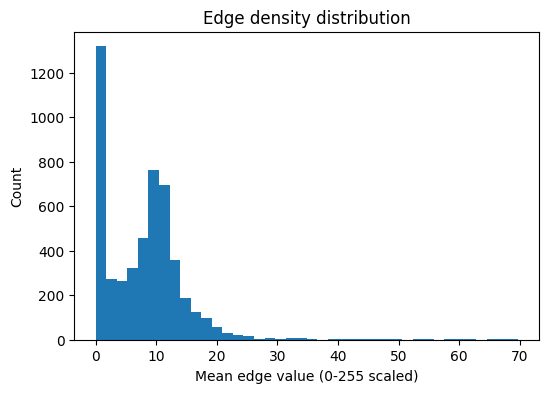

In [31]:
plt.figure(figsize=(6,4))
plt.hist(df["edge_density"], bins=40)
plt.title("Edge density distribution")
plt.xlabel("Mean edge value (0-255 scaled)")
plt.ylabel("Count")
plt.show()


In [32]:
# Common Arabic diacritics Unicode range
DIACRITICS = "".join(chr(c) for c in range(0x064B, 0x065F))

def count_diacritics(text):
    return sum(1 for ch in text if ch in DIACRITICS)

df["diacritic_count"] = df["label"].astype(str).apply(count_diacritics)
df["diacritic_count"].describe()


,diacritic_count
count,5032.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


In [33]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df["class"]
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    random_state=42,
    stratify=temp_df["class"]
)

print("Train:", len(train_df), "Val:", len(val_df), "Test:", len(test_df))
print("Train style dist:\n", train_df["class"].value_counts())


Train: 4025 Val: 503 Test: 504
Train style dist:
 class
Naskh       2987
Thuluth      808
Diwani       194
Kufic         22
Muhaquaq      14
Name: count, dtype: int64


In [34]:
train_df.to_csv(ALL_DIR / "labels_train.csv", index=False)
val_df.to_csv(ALL_DIR / "labels_val.csv", index=False)
test_df.to_csv(ALL_DIR / "labels_test.csv", index=False)


# **--------------Preprocessing----------------**

In [35]:
import os
from pathlib import Path

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt


In [36]:
RAW_DIR = Path("/content/drive/MyDrive/EECE693_Project/Full_Dataset/All")
RAW_IMAGES = RAW_DIR / "images"
RAW_LABELS = RAW_DIR / "labels.csv"

OUT_DIR = Path("/content/drive/MyDrive/EECE693_Project/Preprocessed_HICMA")
OUT_IMAGES = OUT_DIR / "images"
OUT_LABELS = OUT_DIR / "labels.csv"

OUT_DIR.mkdir(parents=True, exist_ok=True)
OUT_IMAGES.mkdir(parents=True, exist_ok=True)


In [37]:
TARGET_HEIGHT = 256      # you can change to 320/384 later if you want
MIN_H = 50               # drop very small images
MIN_W = 100
PAD_DIVISOR = 32         # pad width to multiple of 32 (good for Swin/ViT etc.)

# prepare CLAHE once
clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(8, 8))

def preprocess_image(src_path: Path,
                     dst_path: Path,
                     target_height: int = TARGET_HEIGHT,
                     min_h: int = MIN_H,
                     min_w: int = MIN_W,
                     pad_divisor: int = PAD_DIVISOR):
    """
    Returns (new_h, new_w) if processed and saved, or None if image skipped.
    """
    # 1) load grayscale
    img = cv2.imread(str(src_path), cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None

    h, w = img.shape[:2]

    # 2) drop tiny images
    if h < min_h or w < min_w:
        return None

    # 3) mild normalization (CLAHE)
    img = clahe.apply(img)

    # 4) resize to fixed height, preserve aspect ratio
    scale = target_height / float(h)
    new_w = int(round(w * scale))
    img_resized = cv2.resize(img, (new_w, target_height),
                             interpolation=cv2.INTER_AREA)

    # 5) letterbox padding to multiple-of-32 width
    if pad_divisor is not None:
        padded_w = int(np.ceil(new_w / pad_divisor) * pad_divisor)
    else:
        padded_w = new_w

    canvas = np.full((target_height, padded_w), 255, dtype=np.uint8)  # white bg
    x0 = (padded_w - new_w) // 2
    canvas[:, x0:x0+new_w] = img_resized

    # 6) save as PNG (lossless)
    cv2.imwrite(str(dst_path), canvas)

    return target_height, padded_w


In [38]:
# load original labels
df_raw = pd.read_csv(RAW_LABELS)

# drop unnamed index column if present
first_col = df_raw.columns[0]
if first_col.lower().startswith("unnamed"):
    df_raw = df_raw.drop(columns=[first_col])

# just to be safe
df_raw["img_name"] = df_raw["img_name"].astype(str).str.strip()

processed_rows = []
skipped_missing = []
skipped_tiny = []

for idx, row in tqdm(df_raw.iterrows(), total=len(df_raw)):
    img_name = row["img_name"]
    src = RAW_IMAGES / img_name

    if not src.exists():
        skipped_missing.append(img_name)
        continue

    # keep the same base name but use .png for preprocessed version
    stem = src.stem
    dst_name = stem + ".png"
    dst = OUT_IMAGES / dst_name

    res = preprocess_image(src, dst)
    if res is None:
        skipped_tiny.append(img_name)
        continue

    new_h, new_w = res

    new_row = row.copy()
    new_row["img_name"] = dst_name
    new_row["height"] = new_h
    new_row["width"] = new_w
    processed_rows.append(new_row)

df_proc = pd.DataFrame(processed_rows)

df_proc.to_csv(OUT_LABELS, index=False)

print("Total original rows: ", len(df_raw))
print("Processed rows     : ", len(df_proc))
print("Skipped (missing)  : ", len(skipped_missing))
print("Skipped (tiny)     : ", len(skipped_tiny))


100%|██████████| 5032/5032 [06:05<00:00, 13.77it/s]


Total original rows:  5032
Processed rows     :  5025
Skipped (missing)  :  0
Skipped (tiny)     :  7


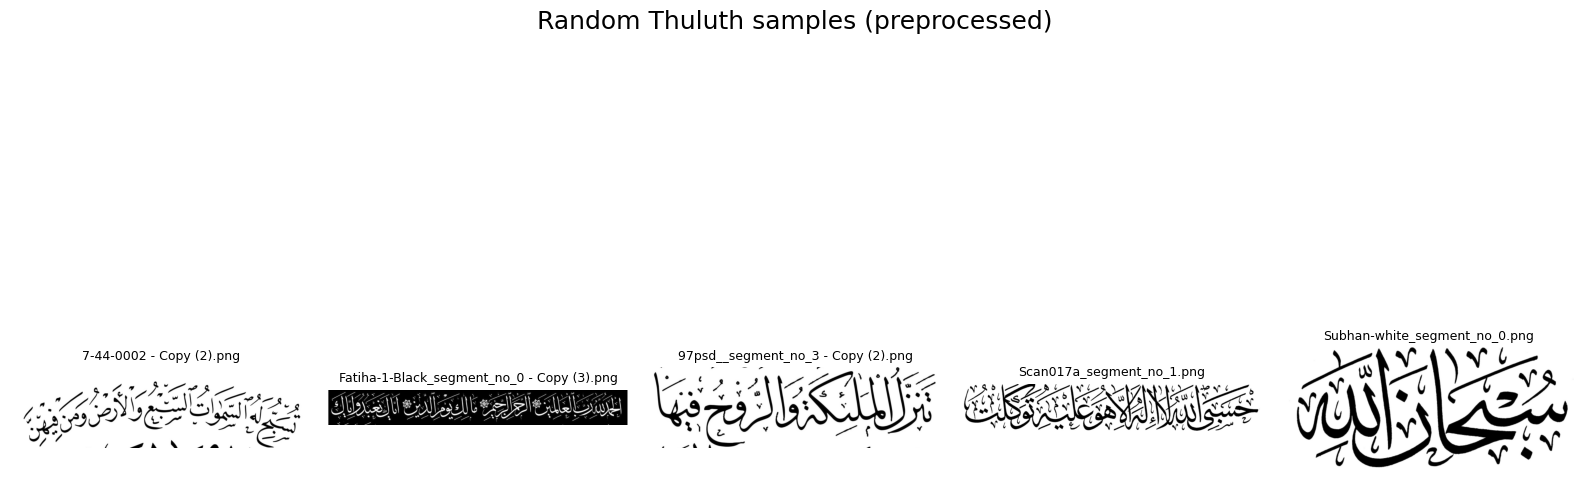

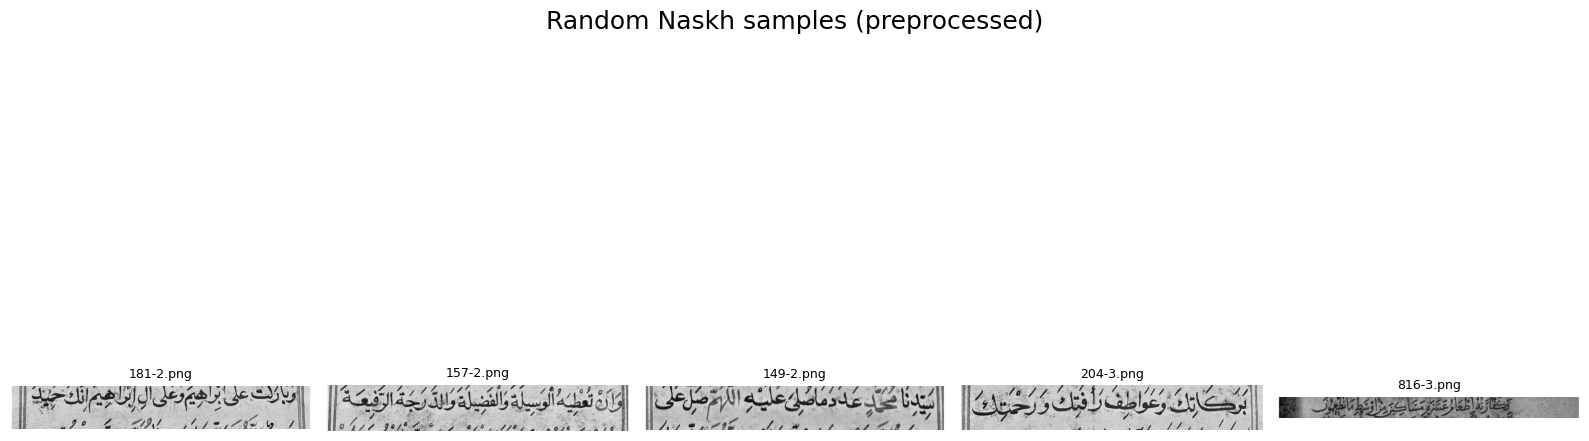

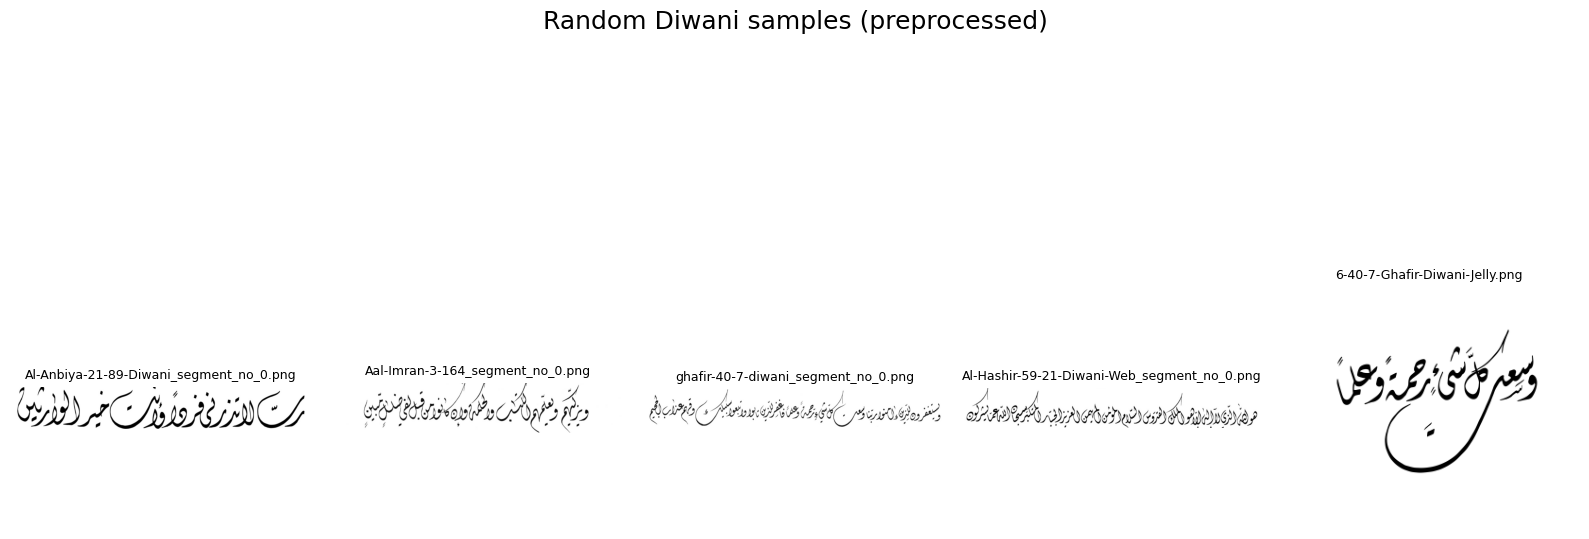

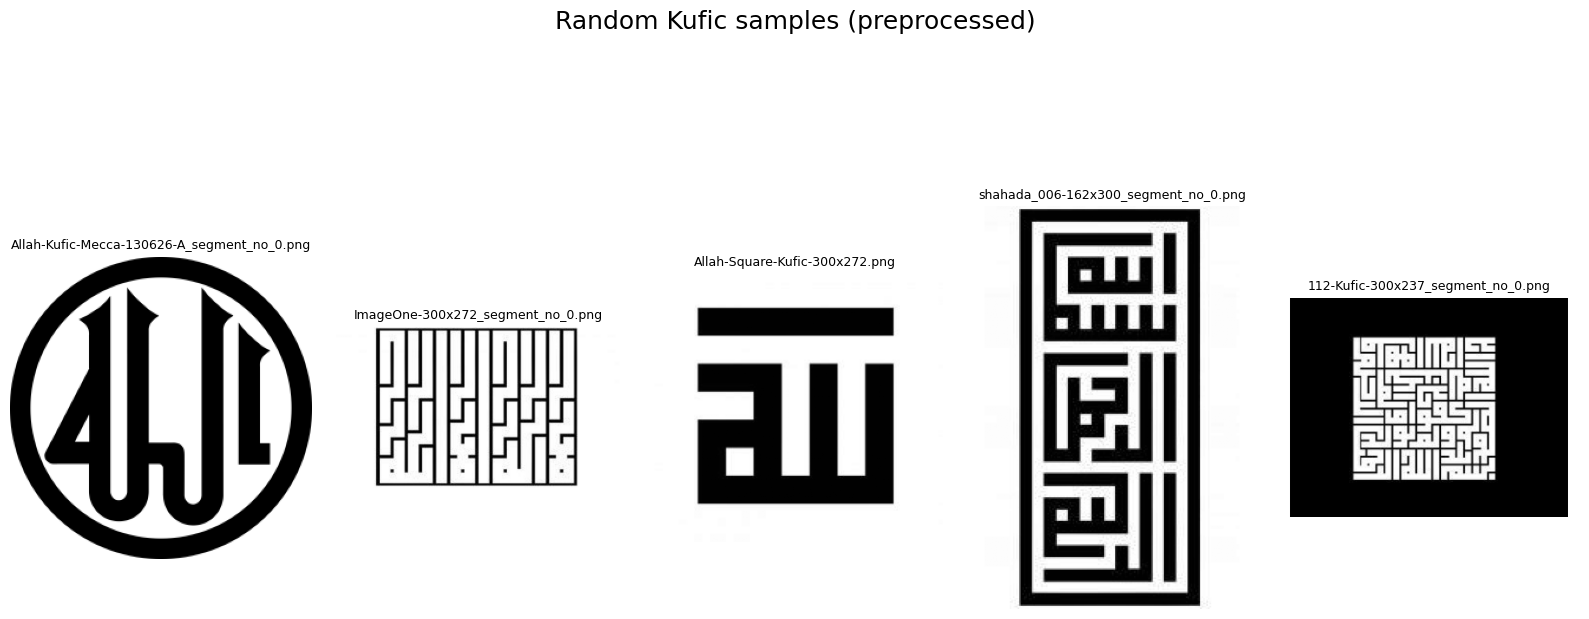

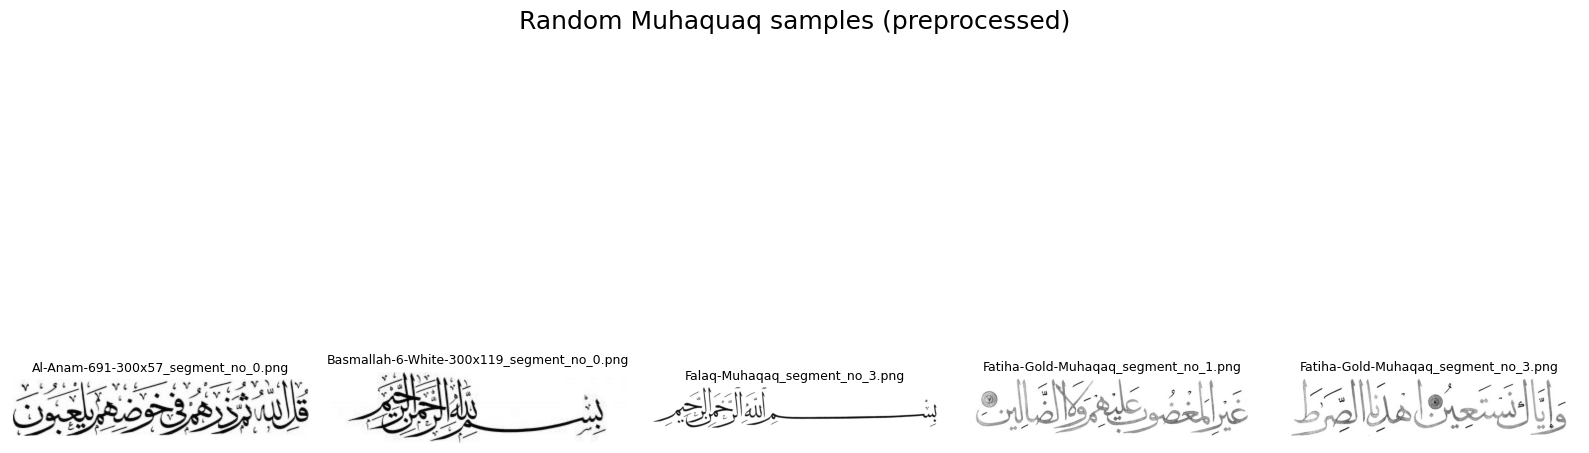

In [39]:
# reload processed labels (just to be sure)
df_proc = pd.read_csv(OUT_LABELS)

styles = df_proc["class"].unique()
num_samples_per_style = 5

for style in styles:
    sub = df_proc[df_proc["class"] == style]
    if len(sub) == 0:
        continue

    n_show = min(num_samples_per_style, len(sub))
    sample_rows = sub.sample(n_show, random_state=42)

    plt.figure(figsize=(16, 3 * n_show / 2))
    plt.suptitle(f"Random {style} samples (preprocessed)", fontsize=18)

    for i, (_, r) in enumerate(sample_rows.iterrows(), start=1):
        img_path = OUT_IMAGES / r["img_name"]
        img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)

        plt.subplot(1, n_show, i)
        plt.imshow(img, cmap="gray")
        plt.axis("off")
        plt.title(r["img_name"], fontsize=9)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


# **--------------Splitting----------------**

In [41]:
import os
from pathlib import Path
import shutil

import pandas as pd
from sklearn.model_selection import train_test_split


In [42]:
BASE_DIR = Path("/content/drive/MyDrive/EECE693_Project/Preprocessed_HICMA")
ALL_IMAGES = BASE_DIR / "images"
LABELS_PATH = BASE_DIR / "labels.csv"

TRAIN_DIR = BASE_DIR / "train" / "images"
VAL_DIR   = BASE_DIR / "val"   / "images"
TEST_DIR  = BASE_DIR / "test"  / "images"

for d in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
    d.mkdir(parents=True, exist_ok=True)


In [43]:
df = pd.read_csv(LABELS_PATH)

# make sure img_name is string and strip spaces
df["img_name"] = df["img_name"].astype(str).str.strip()

# drop any rows whose image is missing (just in case)
df = df[df["img_name"].apply(lambda n: (ALL_IMAGES / n).exists())].reset_index(drop=True)

print("Total samples available:", len(df))

# first split: train vs temp (val+test)
df_train, df_temp = train_test_split(
    df,
    test_size=0.2,
    stratify=df["class"],
    random_state=42,
)

# second split: val vs test (half-half of temp)
df_val, df_test = train_test_split(
    df_temp,
    test_size=0.5,
    stratify=df_temp["class"],
    random_state=42,
)

print("Train:", len(df_train), "Val:", len(df_val), "Test:", len(df_test))


Total samples available: 5025
Train: 4020 Val: 502 Test: 503


In [44]:
def copy_split(df_split, dest_dir: Path):
    for _, row in df_split.iterrows():
        img_name = row["img_name"]
        src = ALL_IMAGES / img_name
        dst = dest_dir / img_name
        if not src.exists():
            continue
        shutil.copy2(src, dst)


In [45]:
# copy images
copy_split(df_train, TRAIN_DIR)
copy_split(df_val,   VAL_DIR)
copy_split(df_test,  TEST_DIR)


In [46]:
df_train.to_csv(BASE_DIR / "train_labels.csv", index=False)
df_val.to_csv(BASE_DIR / "val_labels.csv", index=False)
df_test.to_csv(BASE_DIR / "test_labels.csv", index=False)


In [47]:
print("Overall:")
print(df["class"].value_counts(), "\n")

print("Train:")
print(df_train["class"].value_counts(), "\n")

print("Val:")
print(df_val["class"].value_counts(), "\n")

print("Test:")
print(df_test["class"].value_counts())


Overall:
class
Naskh       3735
Thuluth     1010
Diwani       237
Kufic         26
Muhaquaq      17
Name: count, dtype: int64 

Train:
class
Naskh       2988
Thuluth      808
Diwani       190
Kufic         21
Muhaquaq      13
Name: count, dtype: int64 

Val:
class
Naskh       373
Thuluth     101
Diwani       23
Kufic         3
Muhaquaq      2
Name: count, dtype: int64 

Test:
class
Naskh       374
Thuluth     101
Diwani       24
Muhaquaq      2
Kufic         2
Name: count, dtype: int64
